# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime

import re

In [2]:
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
spark = SparkSession.builder \
    .appName("zdd Sparkify") \
.getOrCreate()


In [4]:
#小数据集
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
#中等数据集
path = 'medium-sparkify-event-data.json'
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [5]:
df.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            543705|
|   mean|2040.8143533717732|
| stddev|1434.3389310782754|
|    min|                 1|
|    max|              4808|
+-------+------------------+



In [6]:
df.groupby('userid').count().sort(desc('userid')).show()

+------+-----+
|userid|count|
+------+-----+
|    99| 1205|
|    98| 3206|
|    97| 1563|
|    96| 2304|
|    95| 2448|
|    94|  132|
|    93| 1953|
|    92| 9767|
|    91|  555|
|    90|  756|
|     9| 2596|
|    89|  396|
|    88| 2359|
|    87| 5243|
|    86| 1968|
|    85| 2696|
|    83| 1668|
|    82| 1445|
|    81| 1974|
|    80| 1356|
+------+-----+
only showing top 20 rows



In [7]:
df.count()

543705

In [8]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"]) 

In [9]:
df_valid.count()

543705

In [10]:
df_valid.filter(df_valid["sessionId"] != "").count()

0

In [11]:
df_valid.filter(df_valid["userId"] != "").count()

528005

In [12]:
df = df_valid.filter(df_valid["userId"] != "")

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [13]:
df.groupby('page').count().sort('count').show()
#df.select('page').dropDuplicates().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    99|
|Cancellation Conf...|    99|
|    Submit Downgrade|   117|
|      Submit Upgrade|   287|
|               Error|   503|
|       Save Settings|   585|
|             Upgrade|   968|
|               About|  1026|
|                Help|  2644|
|            Settings|  2964|
|           Downgrade|  3811|
|         Thumbs Down|  4911|
|              Logout|  5990|
|         Roll Advert|  7773|
|          Add Friend|  8087|
|     Add to Playlist| 12349|
|                Home| 19089|
|           Thumbs Up| 23826|
|            NextSong|432877|
+--------------------+------+



In [66]:
df.groupby('page').count().sort('count').toPandas()

,page,count
0,Cancel,99
1,Cancellation Confirmation,99
2,Submit Downgrade,117
3,Submit Upgrade,287
4,Error,503
5,Save Settings,585
6,Upgrade,968
7,About,1026
8,Help,2644
9,Settings,2964


### *添加churn*

In [14]:
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list).cast('int'))

### *1.gender探索*

In [ ]:
df_churn = df_withchurn.dropDuplicates(["userId"]).groupby(["churn"]).count().withColumnRenamed("count", "churncount")
get_Freq = udf(lambda x,y : (x/y)*100)

In [16]:
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|  196|
|    0|     F|  153|
|    1|     F|   45|
|    1|     M|   54|
+-----+------+-----+



In [57]:
df_g = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().withColumnRenamed("count", "genderccount")

In [59]:
df_gendercount = df_g.join(df_churn, 'churn')
df_gendercount.withColumn("gender_Freq", get_Freq(df_gendercount.genderccount, df_gendercount.churncount).cast('float')).sort("churn").show()

+-----+------+------------+----------+-----------+
|churn|gender|genderccount|churncount|gender_Freq|
+-----+------+------------+----------+-----------+
|    0|     M|         196|       349|  56.160458|
|    0|     F|         153|       349|  43.839542|
|    1|     F|          45|        99|  45.454544|
|    1|     M|          54|        99|  54.545456|
+-----+------+------------+----------+-----------+



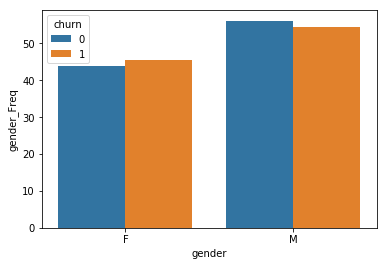

In [61]:
pd_gender = df_gendercount.withColumn("gender_Freq", get_Freq(df_gendercount.genderccount, df_gendercount.churncount).cast('float')).toPandas()
sns.barplot(data=pd_gender, x='gender', y='gender_Freq', hue='churn');

In [ ]:
男性客户流失比例要稍高于女性客户

### *2.artist探索*

In [18]:
df_withchurn.groupby(["churn"]).count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|103646|
|    0|424359|
+-----+------+



In [19]:
df_withchurn.dropDuplicates(["churn", "artist"]).groupby(["churn"]).count().withColumnRenamed("count", "artistcount").sort("churn").show()

+-----+-----------+
|churn|artistcount|
+-----+-----------+
|    0|      19993|
|    1|      12152|
+-----+-----------+



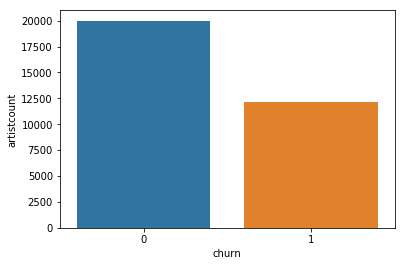

In [20]:
df_artist = df_withchurn.dropDuplicates(["churn", "artist"]).groupby(["churn"]).count().withColumnRenamed("count", "artistcount").sort("churn").toPandas()
sns.barplot(x="churn", y="artistcount", data=df_artist);

In [ ]:
流失用户关注的歌手数量比活跃用号关注的歌手数量明显要少的多

### *3.level探索*

In [36]:
df_withchurn.createOrReplaceTempView("dftable")
df_level = spark.sql('''
select
userId, level,churn
from(SELECT userId, level,churn,
                      row_number() over(partition by userId order by ts desc) rank
                      FROM dftable)
where rank = 1
order by userId
'''
)

In [37]:
df_level.groupby(["level","churn"]).count().show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|    0|  209|
| free|    0|  140|
| paid|    1|   67|
| free|    1|   32|
+-----+-----+-----+



In [199]:
df_l = df_level.groupby(["level","churn"]).count().withColumnRenamed("count", "levelccount")

In [200]:
df_levelcount = df_l.join(df_churn, 'churn')
df_levelcount.withColumn("level_Freq", get_Freq(df_levelcount.levelccount, df_levelcount.churncount).cast('float')).sort("churn").show()

+-----+-----+-----------+----------+----------+
|churn|level|levelccount|churncount|level_Freq|
+-----+-----+-----------+----------+----------+
|    0| paid|        209|       349| 59.885387|
|    0| free|        140|       349| 40.114613|
|    1| paid|         67|        99| 67.676765|
|    1| free|         32|        99|  32.32323|
+-----+-----+-----------+----------+----------+



In [203]:
pd_level = df_levelcount.withColumn("level_Freq", get_Freq(df_levelcount.levelccount, df_levelcount.churncount).cast('float')).toPandas()

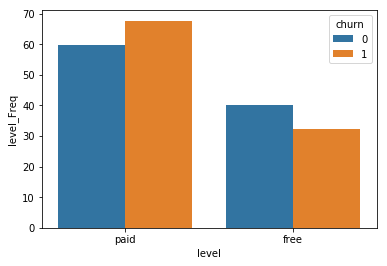

In [204]:
sns.barplot(data=pd_level, x='level', y='level_Freq', hue='churn');

In [ ]:
付费状态下客户流失多，付费状态下客户流失少，故可以作为特征列

### *4.page探索*

In [84]:
df_page = spark.sql('''
select 
t1.page, 
t1.churn,
t1.pc_count/(t2.p_count*t3.c_count) Freq

from (SELECT 
          page, churn,
          count(page) pc_count
                
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by page, churn) t1
left join (SELECT 
          page,
          count(page) p_count
                
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by page) t2 on t1.page = t2.page
left join (SELECT churn,
           count(page) c_count
                
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by churn) t3 on t1.churn = t3.churn
'''
)

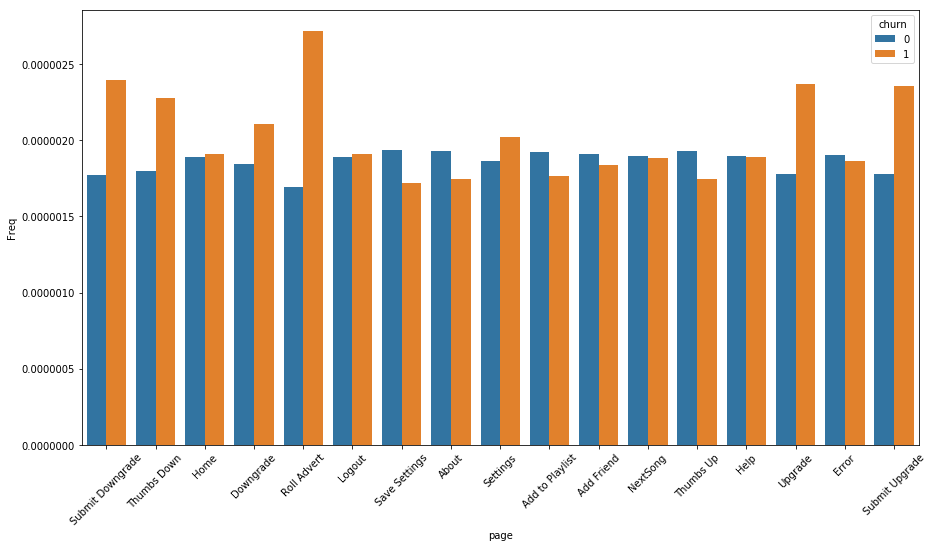

In [88]:
plt.figure(figsize=[15,8])
sns.barplot(data=pd_page, x='page', y='Freq', hue='churn');
plt.xticks(rotation=45);

In [ ]:
如上图所示，Submit Downgrade、Thumbs Down、Downgrade、Roll Advert、Upgrade、Submit Downgrade页面的流失客户与活跃客户比例差别较大

### *5.sessionId探索*

In [89]:
df_withchurn.select(["churn", "sessionId"]).groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|103646|
|    0|424359|
+-----+------+



In [90]:
df_withchurn.select(["churn", "sessionId"]).groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1| 1072|
|    0| 3861|
+-----+-----+



In [91]:
df_withchurn.select(["churn", "sessionId"]).groupby("churn").count().show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    1|96.68470149253731|
|    0|109.9090909090909|
+-----+-----------------+



In [ ]:
流失客户和活跃客户的sessionId的平均会议次数差别较大

### *6.songs探索*

In [99]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day, IntegerType())
df_withchurn = df_withchurn.withColumn("time", get_time(df_withchurn.ts))                                                                              
df_withchurn = df_withchurn.withColumn("day_time", get_month(df_withchurn.ts)*31+get_day(df_withchurn.ts)-310)

In [133]:
df_d = df_withchurn.filter(df_withchurn.page=="NextSong").groupby(["churn", "day_time"]).count().sort('day_time','churn').withColumnRenamed("count", "songccount")

In [198]:
df_churn.show()

+-----+----------+
|churn|churncount|
+-----+----------+
|    1|        99|
|    0|       349|
+-----+----------+



In [134]:
get_song = udf(lambda x,y : (x/y))
df_song = df_d.join(df_churn, 'churn')

In [137]:
df_song.withColumn("song_Freq", get_Freq(df_song.songccount, df_song.churncount).cast('float')).show()

+-----+--------+----------+----------+------------------+
|churn|day_time|songccount|churncount|         song_Freq|
+-----+--------+----------+----------+------------------+
|    1|      61|        64|        99| 64.64646464646465|
|    1|      60|       455|        99| 459.5959595959596|
|    1|      59|       334|        99|337.37373737373736|
|    1|      58|       426|        99|430.30303030303025|
|    1|      57|       411|        99| 415.1515151515151|
|    1|      56|       111|        99|112.12121212121211|
|    1|      55|        72|        99| 72.72727272727273|
|    1|      54|       355|        99| 358.5858585858586|
|    1|      53|       393|        99|  396.969696969697|
|    1|      52|       535|        99| 540.4040404040404|
|    1|      51|       853|        99| 861.6161616161615|
|    1|      50|       327|        99| 330.3030303030303|
|    1|      49|       470|        99| 474.7474747474747|
|    1|      48|       244|        99|246.46464646464645|
|    1|      4

In [150]:
song_pd = df_song.withColumn("song_Freq", get_Freq(df_song.songccount, df_song.churncount).cast('float')).sort('day_time').toPandas()

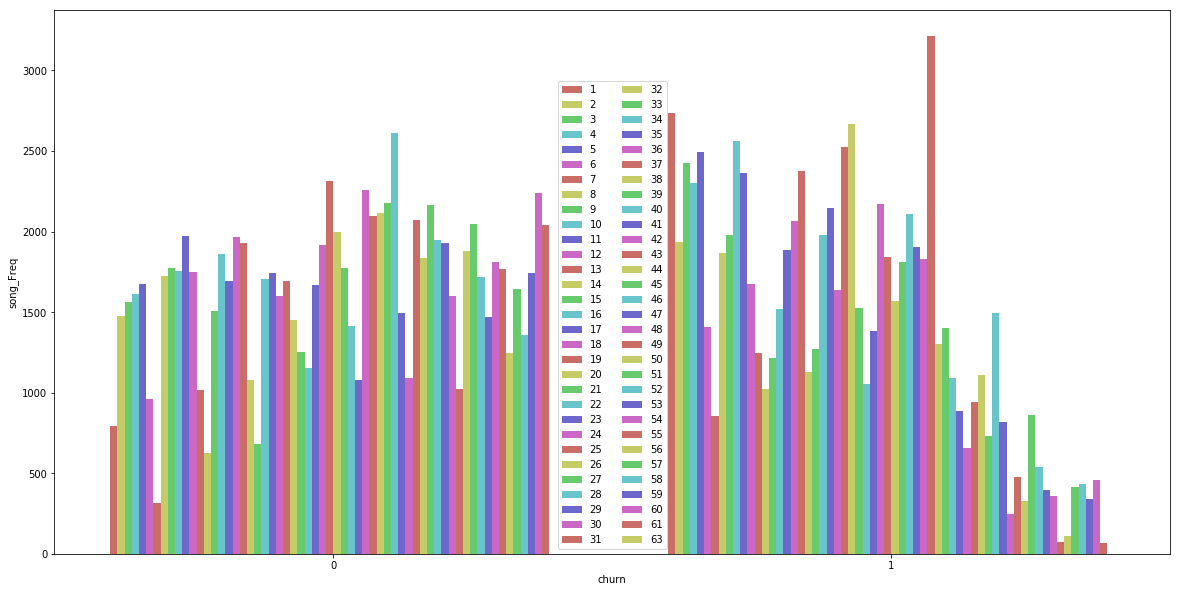

In [147]:
plt.figure(figsize=[20,10])
sns.barplot(data=song_pd , x='churn', y='song_Freq', hue='day_time',palette=sns.color_palette("hls"));
plt.legend(ncol=2);

In [149]:
song_pd.groupby('churn')['songccount'].mean()

churn
0    5621.258065
1    1382.934426
Name: songccount, dtype: float64

In [ ]:
活跃的用户和流失的用户平均每天听歌的数量差距很明显，可作为特征列

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [151]:
df_withchurn = df_withchurn.replace(["M", "F"],["0", "1"], "gender")
df_withchurn = df_withchurn.replace(["free", "paid"], ["0", "1"], "level")

In [152]:
df_withchurn = df_withchurn.withColumn("gender_num", df_withchurn.gender.cast('int'))
df_withchurn = df_withchurn.withColumn("level_num", df_withchurn.level.cast('int'))

In [153]:
df_withchurn.count()

528005

In [73]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day, IntegerType())
df_withchurn = df_withchurn.withColumn("time", get_time(df_withchurn.ts))                                                                              
df_withchurn = df_withchurn.withColumn("day_time", get_month(df_withchurn.ts)*31+get_day(df_withchurn.ts)-310)

In [154]:
df_withchurn.groupby('time','day_time').count().sort('time').show(100)

+----------+--------+-----+
|      time|day_time|count|
+----------+--------+-----+
|2018-10-01|       1| 6977|
|2018-10-02|       2| 8821|
|2018-10-03|       3| 9888|
|2018-10-04|       4| 9893|
|2018-10-05|       5|10353|
|2018-10-06|       6| 5956|
|2018-10-07|       7| 2380|
|2018-10-08|       8| 9743|
|2018-10-09|       9|10065|
|2018-10-10|      10|10611|
|2018-10-11|      11|11360|
|2018-10-12|      12| 9540|
|2018-10-13|      13| 5914|
|2018-10-14|      14| 3956|
|2018-10-15|      15| 8028|
|2018-10-16|      16| 9825|
|2018-10-17|      17| 9564|
|2018-10-18|      18|10868|
|2018-10-19|      19|10989|
|2018-10-20|      20| 6036|
|2018-10-21|      21| 4381|
|2018-10-22|      22| 9638|
|2018-10-23|      23|10052|
|2018-10-24|      24| 8820|
|2018-10-25|      25|10191|
|2018-10-26|      26| 9387|
|2018-10-27|      27| 7099|
|2018-10-28|      28| 6163|
|2018-10-29|      29| 8742|
|2018-10-30|      30|10705|
|2018-10-31|      31|12181|
|2018-11-01|      32|10297|
|2018-11-02|      33

In [155]:
# 去掉'2018-12-01'
df_withchurn =  df_withchurn.filter((df_withchurn.time!='2018-12-01'))

In [157]:
df_withchurn.createOrReplaceTempView("dftable")

特性1:**gender**--用户性别

特性2:**artistcount**--用户关注的歌手人数

特性3:**leve**l--用户最后状态是否付费

特性4:**regtime**--用户自注册以来的天数

特性5:**se_avg**-用户sessionId平均会议次数

特性6:**freq_Roll_Advert**---用户使用Roll_Adver页面的频率

特性7:**freq_Submit_Upgrade**--用户使用Submit_Upgrade页面的频率

特性8:**freq_Upgrade**--用户使用Submit Downgrade页面的频率

特性9:**freq_Submit Downgrade**--用户使用Upgrade页面的频率

特性10:**freq_Thumbs Down**--用户使用Thumbs Down页面的频率

特性11:**freq_Downgrade**--用户使用Downgrade页面的频率

特性12: **songs_per_count**--用户平均每天听的歌曲数  

特性13:**time_per_day**--用户平均每天活跃时间 

In [158]:
df_feature1 = spark.sql('''
select 
t1.userId,
t1.gender, 
t1.artistcount,
t2.level,
t1.regtime,
t3.se_avg,
t4.Roll_Advert_count/t4.page_count freq_Roll_Advert,
t4.Submit_Upgrade_count/t4.page_count freq_Submit_Upgrade,
t4.Upgrade_count/t4.page_count freq_Upgrade,
t4.Submit_Downgrade_count/t4.page_count freq_Submit_Downgrade,
t4.Thumbs_Down_count/t4.page_count freq_Thumbs_Down, 
t4.Downgrade_count/t4.page_count freq_Downgrade,
t5.songs_per_count, 
t5.time_per_day,
t1.churn

from  (SELECT 
          userId,
          max(distinct gender_num) gender,
          count(distinct artist) artistcount,
          max(ts)-max(registration) regtime,
          max(distinct churn) churn
          
          FROM dftable 
          group by userId) t1
          
left join(select userId, level_num level
                      from(SELECT userId, level_num,
                      row_number() over(partition by userId order by time desc) rank
                      FROM dftable)
                      where rank = 1
          order by userId) t2 on t1.userId = t2.userId
          
left join(select userId, mean(se_num)  se_avg
          from(SELECT userId, sessionId, count(sessionId) se_num
                  FROM dftable
                  group by userId, sessionId)
          group by userId) t3 on t1.userId = t3.userId

left join(SELECT 
          userId,
          count(case when 
                page = "Roll Advert" 
                then page
                end) Roll_Advert_count,  
          count(case when 
                page = "Submit Upgrade"   
                then page
                end) Submit_Upgrade_count,
          count(case when 
                page = "Upgrade"   
                then page
                end) Upgrade_count,
          count(case when 
                page = "Submit Downgrade" 
                then page
                end) Submit_Downgrade_count, 
          count(case when 
                page = "Thumbs Down"   
                then page
                end) Thumbs_Down_count, 
          count(case when 
                page = "Downgrade"   
                then page
                end) Downgrade_count,
          count(page) page_count
                
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by userId) t4 on t1.userId = t4.userId

left join(select 
           userId,
          avg(songs_count) songs_per_count, 
          avg(time_day) time_per_day

          from  (SELECT 
                    userId,
                    day_time,
                    count(song) songs_count,
                    max(ts) -min(ts) time_day
          
                    FROM dftable 
                    where page ="NextSong"
                    group by userId, day_time)
          group by userId) t5 on t1.userId = t5.userId
          '''
          )

In [159]:
feature1_pd = df_feature1.toPandas()

In [160]:
feature1_pd.head(10)

,userId,gender,artistcount,level,regtime,se_avg,freq_Roll_Advert,freq_Submit_Upgrade,freq_Upgrade,freq_Submit_Downgrade,freq_Thumbs_Down,freq_Downgrade,songs_per_count,time_per_day,churn
0,100010,1,94,0,1237978000,68.500000,0.162963,0.000000,0.014815,0.0,0.022222,0.000000,48.000000,1.260050e+07,1
1,200002,0,287,1,4607120000,79.000000,0.027990,0.002545,0.005089,0.0,0.012723,0.007634,51.666667,1.301050e+07,1
2,296,1,108,1,2301546000,30.400000,0.060000,0.006667,0.006667,0.0,0.000000,0.006667,22.400000,5.521400e+06,1
3,125,0,61,0,9108471000,28.000000,0.071429,0.000000,0.000000,0.0,0.011905,0.000000,20.666667,5.063333e+06,0
4,124,1,1240,1,9724648000,126.823529,0.000464,0.000000,0.000000,0.0,0.006964,0.009749,86.952381,2.404148e+07,1
5,51,0,233,1,1628279000,65.600000,0.003067,0.000000,0.000000,0.0,0.003067,0.012270,44.333333,1.087250e+07,1
6,7,0,407,0,6741774000,40.000000,0.058333,0.000000,0.010000,0.0,0.006667,0.000000,30.800000,1.127533e+07,0
7,200037,0,114,0,3676664000,22.142857,0.058824,0.000000,0.000000,0.0,0.019608,0.000000,17.428571,8.658714e+06,1
8,169,0,111,0,6811920000,18.625000,0.087248,0.000000,0.013423,0.0,0.000000,0.000000,14.000000,3.242875e+06,0
9,205,1,803,1,4497561000,248.800000,0.000000,0.000000,0.000000,0.0,0.008039,0.008039,116.444444,2.894333e+07,0


In [161]:
df_withchurn.groupby('time','day_time').count().sort('time').show(300)

+----------+--------+-----+
|      time|day_time|count|
+----------+--------+-----+
|2018-10-01|       1| 6977|
|2018-10-02|       2| 8821|
|2018-10-03|       3| 9888|
|2018-10-04|       4| 9893|
|2018-10-05|       5|10353|
|2018-10-06|       6| 5956|
|2018-10-07|       7| 2380|
|2018-10-08|       8| 9743|
|2018-10-09|       9|10065|
|2018-10-10|      10|10611|
|2018-10-11|      11|11360|
|2018-10-12|      12| 9540|
|2018-10-13|      13| 5914|
|2018-10-14|      14| 3956|
|2018-10-15|      15| 8028|
|2018-10-16|      16| 9825|
|2018-10-17|      17| 9564|
|2018-10-18|      18|10868|
|2018-10-19|      19|10989|
|2018-10-20|      20| 6036|
|2018-10-21|      21| 4381|
|2018-10-22|      22| 9638|
|2018-10-23|      23|10052|
|2018-10-24|      24| 8820|
|2018-10-25|      25|10191|
|2018-10-26|      26| 9387|
|2018-10-27|      27| 7099|
|2018-10-28|      28| 6163|
|2018-10-29|      29| 8742|
|2018-10-30|      30|10705|
|2018-10-31|      31|12181|
|2018-11-01|      32|10297|
|2018-11-02|      33

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [163]:
df_feature1.persist()

DataFrame[userId: string, gender: int, artistcount: bigint, level: int, regtime: bigint, se_avg: double, freq_Roll_Advert: double, freq_Submit_Upgrade: double, freq_Upgrade: double, freq_Submit_Downgrade: double, freq_Thumbs_Down: double, freq_Downgrade: double, songs_per_count: double, time_per_day: double, churn: int]

In [164]:
df_feature1.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



In [165]:
#path1 = "mini_churn_data.csv"
path1 = "medium_model_data.csv"

In [166]:
df_feature1.write.save(path1, format="csv", header=True)

In [167]:
df_model = spark.read.csv(path1, header=True)
df_model.persist()

DataFrame[userId: string, gender: string, artistcount: string, level: string, regtime: string, se_avg: string, freq_Roll_Advert: string, freq_Submit_Upgrade: string, freq_Upgrade: string, freq_Submit_Downgrade: string, freq_Thumbs_Down: string, freq_Downgrade: string, songs_per_count: string, time_per_day: string, churn: string]

In [168]:
num_features_list = df_model.columns[1:]
for f in num_features_list:
    f_name = f + "_num"
    df_model = df_model.withColumn(f_name, df_model[f].cast("float"))
    df_model = df_model.drop(f)

In [169]:
df_model.persist()

DataFrame[userId: string, gender_num: float, artistcount_num: float, level_num: float, regtime_num: float, se_avg_num: float, freq_Roll_Advert_num: float, freq_Submit_Upgrade_num: float, freq_Upgrade_num: float, freq_Submit_Downgrade_num: float, freq_Thumbs_Down_num: float, freq_Downgrade_num: float, songs_per_count_num: float, time_per_day_num: float, churn_num: float]

### Create a Vector

In [170]:
assembler = VectorAssembler(inputCols=df_model.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(df_model)

### 缩放特征

In [171]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [172]:
data.persist()

DataFrame[userId: string, gender_num: float, artistcount_num: float, level_num: float, regtime_num: float, se_avg_num: float, freq_Roll_Advert_num: float, freq_Submit_Upgrade_num: float, freq_Upgrade_num: float, freq_Submit_Downgrade_num: float, freq_Thumbs_Down_num: float, freq_Downgrade_num: float, songs_per_count_num: float, time_per_day_num: float, churn_num: float, NumFeatures: vector, ScaledNumFeatures: vector]

In [174]:
data1 = data.select(col("churn_num").alias("label"), col("ScaledNumFeatures").alias("features"))

In [175]:
#new
data1.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[2.01136166752172...|
|  0.0|[2.01136166752172...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|[0.0,1.0353386708...|
|  1.0|[0.0,1.1695492393...|
|  0.0|[0.0,2.3566736721...|
|  0.0|[0.0,1.3612786228...|
|  1.0|[2.01136166752172...|
|  0.0|[2.01136166752172...|
|  0.0|[0.0,1.6568614223...|
|  1.0|[2.01136166752172...|
|  0.0|[0.0,0.7940791966...|
|  0.0|[2.01136166752172...|
|  0.0|[0.0,0.7988724312...|
|  1.0|[0.0,0.1741541900...|
|  0.0|[2.01136166752172...|
|  1.0|(13,[1,3,4,5,7,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|[0.0,1.2654139310...|
|  0.0|(13,[1,3,4,5,9,11...|
+-----+--------------------+
only showing top 20 rows



### 分实验和测试数据

In [218]:
train, validation = data1.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [219]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(13,[0,1,3,4,5,11...|
|  0.0|(13,[1,2,3,4,11,1...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|[0.0,0.1933271283...|
|  0.0|[0.0,0.1965226180...|
|  0.0|[0.0,0.2332707499...|
|  0.0|[0.0,0.2987782892...|
|  0.0|[0.0,0.3371241659...|
|  0.0|[0.0,0.3722745529...|
|  0.0|[0.0,0.3962407258...|
|  0.0|[0.0,0.4234023885...|
|  0.0|[0.0,0.4234023885...|
|  0.0|[0.0,0.4585527755...|
+-----+--------------------+
only showing top 20 rows



## 模型1-LogisticRegression()

In [244]:
#建立模型
lrs =  LogisticRegression()
#模型调参 优化模型
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.01, 0.1]) \
    .addGrid(lrs.aggregationDepth,[2, 5]) \
    .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [245]:
#用train数据训练模型   5点38
Model_lrs = crossval_lrs.fit(train)
Model_lrs.avgMetrics  #每个参数组合的模型的准确率

[0.7981382357513518,
 0.7981382357513518,
 0.7250326988261936,
 0.7250326988261936,
 0.7856691478330748,
 0.7856691478330748,
 0.6848285802299887,
 0.6848285802299887,
 0.772774782552758,
 0.772774782552758,
 0.6848285802299887,
 0.6848285802299887]

## 模型2-GBTClassifier()

In [246]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[5, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 8]) \
    .addGrid(gbts.maxBins ,[10, 5]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [247]:
#用train数据训练模型  
Model_gbt = crossval_gbts.fit(train)
Model_gbt.avgMetrics

[0.7501280757146976,
 0.7337342419640472,
 0.7589080088817882,
 0.7612096076355347,
 0.7301498219440458,
 0.721834583538427,
 0.7720054665196484,
 0.757369608928337,
 0.7662156021489562,
 0.7680260877810344,
 0.7301498219440458,
 0.7272136254463435]

### 使用验证数据通过F1得分来评价最佳模型

In [ ]:
def get_model_metrics(model,data,):
    metrics = []
    predict = model.transform(data)
    tp = predict.filter("label = 1 and prediction = 1").count()
    fp = predict.filter("label = 0 and prediction = 1").count()
    fn = predict.filter("label = 1 and prediction = 0").count()
    n =  predict.count()
    accuracy = (n -(fp +fn))/n
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    f1 = 2*precision*recall / (precision+recall)
    metrics.append(accuracy)
    metrics.append(precision)
    metrics.append(recall)
    metrics.append(f1)
    metrics_names = ['accuracy', 'precision', 'recall', 'f1score']
    dfmetrics = pd.DataFrame(metrics,index=metrics_names)
    return dfmetrics

In [249]:
lrs_train = get_model_metrics(Model_lrs,train)
lrs_validation = get_model_metrics(Model_lrs,validation)
gbt_train = get_model_metrics(Model_gbt,train)
gbt_validation = get_model_metrics(Model_gbt,validation)

In [257]:
df_metrics = pd.concat([lrs_train, lrs_validation, gbt_train, gbt_validation], axis=1)
df_metrics.columns = ['Mode_lrs_train', 'Mode_lrs_validation', 'Mode_gbt_train', 'Mode_gbt_validation']
df_metrics

,Mode_lrs_train,Mode_lrs_validation,Mode_gbt_train,Mode_gbt_validation
accuracy,0.826705,0.791667,0.857955,0.770833
precision,0.735294,0.625000,0.935484,0.500000
recall,0.324675,0.227273,0.376623,0.318182
f1score,0.450450,0.333333,0.537037,0.388889


## 结论：由上述图表可看出，模型Mode_gbt在数据validation在f1score大于模型Mode_lrs，故选择模型Mode_gbt来预测数据，分析用户是否会流失

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。